### Import Necessary Libraries

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import pandas as pd
import logging
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize logging
logging.basicConfig(level=logging.INFO)

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

### Define Sentiment Labeling Function

In [2]:
def sentiment_label(compound_score, positive_threshold=0.05, negative_threshold=-0.05):
    """Assign sentiment label based on thresholds."""
    if compound_score >= positive_threshold:
        return 'positive'
    elif compound_score <= negative_threshold:
        return 'negative'
    else:
        return 'neutral'

### Perform Sentiment Analysis

In [3]:
def vader_analysis(text):
    """Return both VADER compound score and sentiment label."""
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    label = sentiment_label(compound_score)
    return pd.Series([compound_score, label], index=['vader_score', 'vader_label'])

### Visualization Functions

In [4]:
def visualize_sentiment_distribution(df):
    """Create a bar plot showing the distribution of sentiment labels."""
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sentiment_counts = df['vader_label'].value_counts()
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment Label")
    plt.ylabel("Count")
    plt.show()

def visualize_compound_score_distribution(df):
    """Create a histogram showing the distribution of compound sentiment scores."""
    plt.figure(figsize=(10, 6))
    sns.histplot(df['vader_score'], bins=30, kde=True)
    plt.title("Compound Score Distribution")
    plt.xlabel("VADER Compound Score")
    plt.ylabel("Frequency")
    plt.show()

### Main Function

In [5]:
def main(input_file, origin_file):
    """Perform sentiment analysis on raw reviews in a CSV file without headers."""
    try:
        # Read the CSV without headers
        df = pd.read_csv(input_file, header=None)
        df_origin = pd.read_csv(origin_file)
        # Use the first column as the text for analysis
        text_column = df.iloc[:, 0]
        print(text_column.head())  # Print first few rows for verification

    except FileNotFoundError:
        raise FileNotFoundError(f"Input file '{input_file}' not found.")
    except pd.errors.EmptyDataError:
        raise ValueError(f"Input file '{input_file}' is empty or invalid.")

    logging.info("Performing sentiment analysis...")
    tqdm.pandas(desc="Apply Vader Analysis")
    results = text_column.progress_apply(vader_analysis)
    df[['vader_score', 'vader_label']] = results

    # Save results to CSV
    output_file = 'Data/VADER/reviews_VADER.csv'
    df.to_csv(output_file, index=False, header=False)
    logging.info(f"Sentiment analysis complete. Results saved to {output_file}.")

    # Visualization
    logging.info("Creating sentiment distribution visualization...")
    visualize_sentiment_distribution(df)
    visualize_compound_score_distribution(df)

    df_predicted = df.iloc[:, [3]]
    new_df_origin = df_origin.iloc[:, [1]]
    print(df_predicted)
    print(new_df_origin)

    conf_matrix = confusion_matrix(new_df_origin, df_predicted)
    print("Confusion Matrix:")

    # Classification Report
    report = classification_report(new_df_origin, df_predicted)
    print("Classification Report:")
    print(report)

### Execute Main Function

INFO:root:Performing sentiment analysis...


0    Great music service, the audio is high quality...
1    Please ignore previous negative rating. This a...
2    This pop-up "Get the best Spotify experience o...
3      Really buggy and terrible to use as of recently
4    Dear Spotify why do I get songs that I didn't ...
Name: 0, dtype: object


Apply Vader Analysis: 100%|██████████| 10000/10000 [00:02<00:00, 3906.47it/s]
INFO:root:Sentiment analysis complete. Results saved to Data/VADER/reviews_VADER.csv.
INFO:root:Creating sentiment distribution visualization...


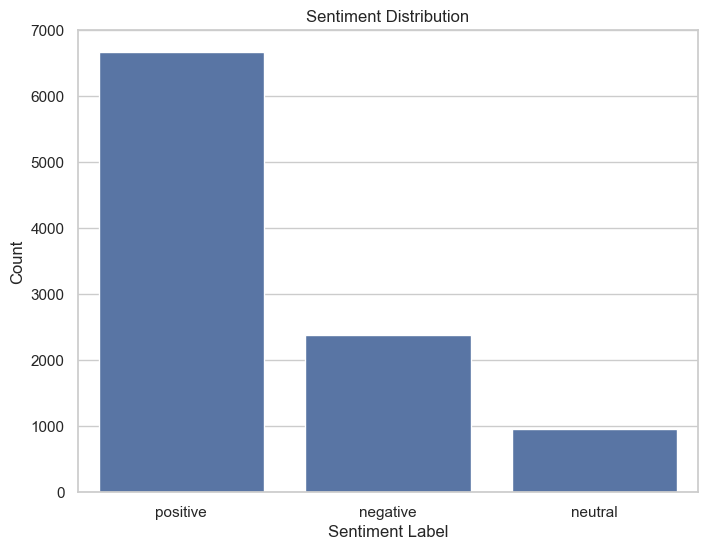

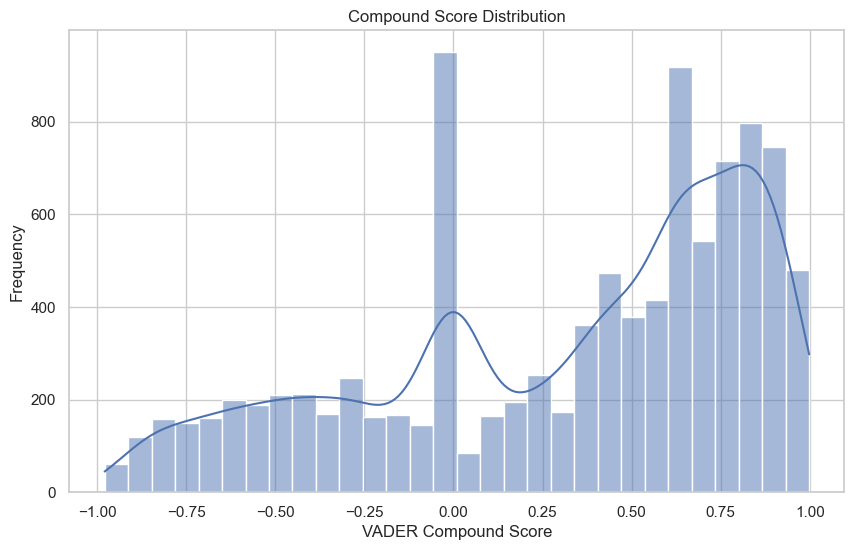

     vader_label
0       positive
1       positive
2       positive
3       negative
4       positive
...          ...
9995    positive
9996    negative
9997    positive
9998    positive
9999     neutral

[10000 rows x 1 columns]
         Label
0     positive
1     positive
2     positive
3     negative
4     negative
...        ...
9995   neutral
9996  negative
9997  positive
9998  positive
9999  negative

[10000 rows x 1 columns]
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.49      0.58      3446
     neutral       0.12      0.11      0.12      1021
    positive       0.72      0.87      0.79      5533

    accuracy                           0.66     10000
   macro avg       0.52      0.49      0.49     10000
weighted avg       0.66      0.66      0.65     10000



In [6]:
if __name__ == "__main__":

    main("Data/ML/reviews_ML_lightweight.csv", "Data/reviews_label_origin.csv")